In [1]:
import psycopg2
from psycopg2 import Error
import json
import gpxpy
import gpxpy.gpx
import time 
import datetime
import pandas as pd
import csv
from collections import Counter

### Connessione al DB

In [2]:
def create_dbconnection():
    with open('data.json') as json_file:
        data = json.load(json_file)
    try:
        connection = psycopg2.connect(user=data['user'],
                                      password=data['password'],
                                      host="127.0.0.1",
                                      port=data['port'],
                                      database=data['database'])
        return connection

    except (Exception, Error) as error:
        print("Error while connecting to PostgreSQL", error)

In [3]:
connection = create_dbconnection()
cursor = connection.cursor()

### Generali

Il sistema di coordinate è 4326 perchè non da problemi di visualizzazione in QGIS, ma ridà la ST_DISTANCE in gradi.

Il sistema di coordinate 3857 è usato nelle operazioni: ST_DISTANCE viene ridata in metri invece che in gradi

### Inserimento traiettoria nel db

In [4]:
# nome della traiettoria
TABLE = 't2'

In [5]:
id_point = 0

query = """ DROP TABLE IF EXISTS """ + TABLE + """ ;
            CREATE TABLE """ + TABLE + """ (
            id serial, 
            LAT numeric, 
            LON numeric, 
            geom GEOMETRY(Point, 4326),
            time TIMESTAMP);"""
cursor.execute(query)
connection.commit()

gpx_file = open('{}.gpx'.format(TABLE) , 'r') 
gpx = gpxpy.parse(gpx_file) 

for track in gpx.tracks: 
    for segment in track.segments: 
        for point in segment.points: 
            insert_query = """INSERT INTO """ + TABLE + """(id,lat,lon,geom, time) 
            VALUES({},{},{},ST_GeomFromText('POINT({} {})', 4326), timestamp '{}');
            """.format(id_point, point.latitude, point.longitude, point.longitude, point.latitude, 
                       (point.time).strftime("%Y-%m-%d %H:%M:%S"))

            id_point += 1
            cursor.execute(insert_query)
            connection.commit()

### Data preprocessing - Map matching
Se si vuol fare una prova semplice si può creare ed utilizzare la tabella "part" per selezionare un sottoinsieme di punti su cui applicare il map matching (è un'operazione lunga, richiede un po' di tempo per applicarlo a tutti i punti della traccia)

In [6]:
query = """
        drop table if exists {0}_mapmatching; 
        create table {0}_mapmatching as 
        select pid, st_lineInterpolatePoint(mgeom, st_lineLocatePoint(mgeom, pgeom))
        from (select distinct on(pt.id) pt.id as pid, mi.id as mid, pt.geom as pgeom, mi.geom as mgeom,
              st_distance(st_transform(pt.geom, 3857), 
                          st_transform(st_lineInterpolatePoint(mi.geom, st_lineLocatePoint(mi.geom, pt.geom)), 3857)) as dis
        from {0} as pt, stradevicine as mi
        order by pid, dis) as ptroads
        where ptroads.dis < 20
        """.format(TABLE)

cursor.execute(query)
connection.commit()

mapmatching contiene le geometrie dei punti che sono stati interpolati, ma devo avere una tabella generale che contiene
sia questi punti sia quelli che sono rimasti nella posizione originale

In [7]:
query = """ 
            drop table if exists {0}_final_points; 
            create table {0}_final_points as (
                select * from {0}  
                left join  {0}_mapmatching
                on {0}.id = {0}_mapmatching.pid); 

            ALTER TABLE {0}_final_points
                ADD final_geom geometry;
        """.format(TABLE)

cursor.execute(query)
connection.commit()

In [8]:
# Selezione punti proiettati - con geom modificata espressa da st_lineinterpolarepoint
query = "select st_lineinterpolatepoint, id from {0}_final_points where id = pid ".format(TABLE)
cursor.execute(query)
risultati1 = cursor.fetchall()

# Selezione punti rimasti uguali - hanno pid nulla dal leftjoin
query = "select geom, id from {0}_final_points where pid is null".format(TABLE)
cursor.execute(query)
risultati2 = cursor.fetchall()

risultati = risultati1 + risultati2 

for element in risultati: 
    query = "UPDATE {0}_final_points set final_geom = '{1}' where id = {2}".format(TABLE, str(element[0]), str(element[-1]))
    cursor.execute(query)
    connection.commit()

In [9]:
cursor.execute("drop table if exists {0}_mapmatching".format(TABLE))
connection.commit()

query = """alter table {0}_final_points
    DROP COLUMN geom, DROP COLUMN pid, DROP COLUMN st_lineinterpolatepoint, ADD time2 timestamp;
    UPDATE {0}_final_points SET time2 = time;
    alter table {0}_final_points DROP COLUMN time;   
    alter table {0}_final_points RENAME COLUMN time2 TO time;
    alter table {0}_final_points RENAME COLUMN final_geom to geom;
    """.format(TABLE)

cursor.execute(query)
connection.commit()

### Creazione tabella waypoint

In [10]:
query = """ 
        DROP TABLE IF EXISTS {0}_waypoint;
        CREATE TABLE {0}_waypoint (id serial, LAT numeric, LON numeric, geom GEOMETRY(Point, 4326), time TIMESTAMP); 
        """.format(TABLE)

cursor.execute(query)
connection.commit()

gpx_file = open('{}.gpx'.format(TABLE) , 'r') 
gpx = gpxpy.parse(gpx_file) 
id_point = 0

for point in gpx.waypoints: 
    insert_query = """ INSERT INTO {}_waypoint(id,lat,lon,geom, time) 
            VALUES({},{},{},ST_GeomFromText('POINT({} {})',4326),'{}');
            """.format(TABLE, id_point, point.latitude, point.longitude, point.longitude, point.latitude, 
                       (point.time).strftime("%Y-%m-%d %H:%M:%S"))
    id_point += 1
    cursor.execute(insert_query)
    connection.commit()

### Distribuzioni distanza e tempo

In [54]:
cursor.execute('SELECT * FROM {}_final_points'.format(TABLE))
data = cursor.fetchall()
num_points = len(data)-1

i = 0
j = i+1
dists_coppie = []
times_coppie = []
while i < num_points:
    dists_coppie.append(delta_dist(data[i][3], data[j][3]))
    times_coppie.append(abs(delta_time(data[i][4], data[j][4])/60)) 
    i = j
    j += 1 

stat. descrittiva distanze: 44.7188399259028 162.1199248714619 612.4635149808437
stat. descrittiva tempi: 0.8166666666666667 7.7774678111587985 28.526666666666685


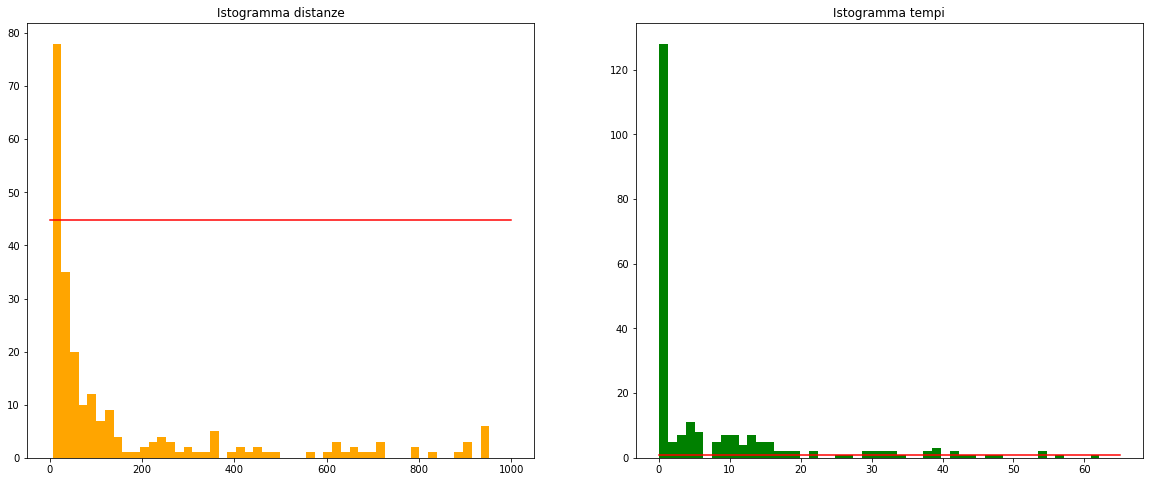

In [94]:
import matplotlib.pyplot as plt
import numpy as np
x0 = np.linspace(0, 1000)
x1 = np.linspace(0, 65)
fig, axs = plt.subplots(1,2, figsize = (20,8))
axs[0].hist(dists_coppie, bins = 50, color = 'orange')
axs[0].plot(x0, [np.median(dists_coppie) for i in x0], color='red')
axs[0].set_title('Istogramma distanze')
axs[1].hist(times_coppie, bins = 50, color = 'green')
axs[1].plot(x1, [np.median(times_coppie) for i in x1], color = 'red')
axs[1].set_title('Istogramma tempi')

print('stat. descrittiva distanze:', np.median(dists_coppie), np.mean(dists_coppie), np.percentile(dists_coppie, 90))
print('stat. descrittiva tempi:', np.median(times_coppie), np.mean(times_coppie), np.percentile(times_coppie, 90))

### Stay point detection

In [11]:
def delta_dist(x, y): # X,Y geom
    cursor.execute("select st_distance(ST_TRANSFORM('{}', 3857),ST_TRANSFORM('{}', 3857));".format(str(x), str(y)))
    dd = cursor.fetchall()
    return dd[0][0]

def delta_time(x, y): # X,Y timestamp
    dt = y-x
    return dt.total_seconds()

def calc_centroide(listapunti, table = TABLE): # X,Y id dei punti
    listapunti = tuple(listapunti)
    query = """ SELECT ST_CENTROID(st_union(t.geom)) as cent_point 
                FROM {} as t
                WHERE t.id in {} """.format(TABLE, listapunti) 
    cursor.execute(query)
    centroide = cursor.fetchall()
    geom_cent = centroide[0][0]
    return geom_cent

In [12]:
def staypoint(distThre, timeThre):
    cursor.execute("select distinct * from {} order by id".format(TABLE))
    data = cursor.fetchall()
    
    query = """ ALTER TABLE {0}_final_points DROP COLUMN IF EXISTS id_centroide;     
                ALTER TABLE {0}_final_points ADD COLUMN id_centroide INTEGER """.format(TABLE)
    cursor.execute(query)
    connection.commit()
    
    i = 0
    num_points = len(data)
    id_centroide = 0
    stay_points = []
    
    while i < len(data)-1:
        j = i+1
        
        while j < num_points:
            
            dist = delta_dist(data[i][3], data[j][3])
    
            if dist > distThre:
                temp = delta_time(data[i][4], data[j][4])
            
                if temp > timeThre:
                    lista_id = [i for i in range(i,j+1)]
                    query = """ UPDATE {0}_final_points SET id_centroide = {1}
                                WHERE id in {2}""".format(TABLE, id_centroide, tuple(lista_id))
                    cursor.execute(query)
                    connection.commit()
                    geom_cent = calc_centroide(lista_id)
                    time_inizio = data[i][4]
                    time_fine = data[j][4]
                    point = [id_centroide, geom_cent, temp, time_inizio, time_fine]
                    stay_points.append(point)
                    id_centroide += 1
                    
                break
            j += 1
        i = j
        
 
   
    print('Sono stati identificati {} staypoints con sogliadist < {}m e sogliatime > {}s: \n'.format(len(stay_points), distThre, timeThre)) 
    
    cursor.execute(""" DROP TABLE if exists {2}_staypoints_{0}m_{1}s; 
                CREATE TABLE {2}_staypoints_{0}m_{1}s (id varchar, geom geometry, 
                deltat numeric, time_inizio timestamp, time_fine timestamp)""".format(distThre, timeThre, TABLE))
    connection.commit()
    
    for point in stay_points:
        print('staypoint {}: intervallo {}'.format(point[0], point[2]/60))
        cursor.execute(""" INSERT INTO {0}_staypoints_{1}m_{2}s
                    VALUES ({3}, '{4}', {5}, '{6}', '{7}')
                    """.format(TABLE, distThre, timeThre, point[0], point[1], point[2], point[3], point[4]))
        connection.commit()
    
    

In [52]:
metri = 60
secondi = 120
staypoint(metri, secondi)

Sono stati identificati 6 staypoints con sogliadist < 60m e sogliatime > 120s: 

staypoint 0: intervallo 3.2333333333333334
staypoint 1: intervallo 13.166666666666666
staypoint 2: intervallo 2.183333333333333
staypoint 3: intervallo 5.116666666666666
staypoint 4: intervallo 6.55
staypoint 5: intervallo 13.116666666666667


### Risultati staypoint: 
- Detected waypoints
- Distanza media tra waypoint e staypoint
- tot wp / tot sp

In [28]:
total_wp = 0
total_sp = 0
total_detected = 0
total_far_sp = 0

TABLE_WAYPOINTS = TABLE + "_waypoint"
TABLE_STAYPOINTS = TABLE + '_staypoints_' + str(metri) + 'm_' + str(secondi) + 's'

cursor.execute("""ALTER TABLE {0} DROP COLUMN IF EXISTS detected_by_sp;
                 ALTER TABLE {0} ADD COLUMN detected_by_sp INTEGER;

                 ALTER TABLE {1} DROP COLUMN IF EXISTS near_wp;
                 ALTER TABLE {1} ADD COLUMN near_wp INTEGER;""".format(TABLE_WAYPOINTS, TABLE_STAYPOINTS))
connection.commit() #aggiungiamo una colonna detected alle tabelle di waypoint

#Selezioniamo wp vicini a sp
query = """ SELECT wp.id AS wpid, sp.id AS spid
            FROM {0} AS wp, {1} AS sp
            WHERE st_distance(st_transform(wp.geom, 3857),st_transform(sp.geom, 3857)) < 30
        """.format(TABLE_WAYPOINTS, TABLE_STAYPOINTS)
cursor.execute(query)
wp_vicini_sp = cursor.fetchall()

#Aggiorniamo tabella WP e SP settando i booleani in corrispondenza degli id dei punti vicini
for row in wp_vicini_sp: 
    cursor.execute(""" UPDATE {0} SET detected_by_sp = 1 WHERE {0}.id = '{1}'""".format(TABLE_WAYPOINTS, str(row[0])))
    connection.commit()
    cursor.execute(""" UPDATE {0} SET near_wp = 1 WHERE {0}.id = '{1}'""".format(TABLE_STAYPOINTS, row[1]))
    connection.commit()

cursor.execute("SELECT count(detected_by_sp) from {}".format(TABLE_WAYPOINTS))
total_wp_detected = cursor.fetchall()[0][0]

cursor.execute("SELECT count(*) from {}".format(TABLE_WAYPOINTS))
total_wp += cursor.fetchall()[0][0]

cursor.execute("SELECT count(*) from {}".format(TABLE_STAYPOINTS))
total_sp += cursor.fetchall()[0][0]

cursor.execute("SELECT COUNT(*)-count(near_wp) from {}".format(TABLE_STAYPOINTS))
total_far_sp += cursor.fetchall()[0][0]

In [29]:
print("Risultati di staypoint {}m, {}s: ".format(metri,secondi))
print("Percentuale di WP rilevati: ", round(total_wp_detected*100/total_wp,3), '%')
print("Percentuale di staypoint lontati da wp: ", round(total_far_sp*100/total_sp,3), '%')

Risultati di staypoint 50m, 180s: 
Percentuale di WP rilevati:  100.0 %
Percentuale di staypoint lontati da wp:  50.0 %


### DBSCAN

CLUS_INDEX:

    if 0: noise 

    if > 0: appartenenza al cluster di id clus_index


In [30]:
def get_vicini(id_p, eps, tempo, deltat):
    
    if tempo:    
        cursor.execute("""  SELECT t2.id FROM {0}_final_points as t1, {0}_final_points as t2
                        WHERE st_distance(st_transform(t1.geom, 3857), st_transform(t2.geom, 3857)) <= {1} and t1.id = '{2}' 
                        AND abs(extract(epoch from t2.time::timestamp - t1.time::timestamp )) <{3}
                        """.format(TABLE, eps, str(id_p), deltat))
    else:
        cursor.execute(""" SELECT t2.id FROM {0}_final_points as t1, {0}_final_points as t2
                        WHERE st_distance(st_transform(t1.geom, 3857), st_transform(t2.geom, 3857)) <= {1} 
                        AND t1.id = '{2}' """.format(TABLE, eps, id_p))
    
    data = cursor.fetchall()
    vicini = []
    for i in range(len(data)):
        vicini.append(int(data[i][0]))
        
    return vicini
    
def espansione_cluster(p, vicinato, cluster_index, eps, minpts, labels, tempo, deltat):
    seed = vicinato
    for nodo in seed:
        if labels[nodo] == -1 or labels[nodo] == 0: # non visitato o noise
            labels[nodo] = cluster_index            
            vicini_nodo = get_vicini(nodo, eps, tempo, deltat)
            if len(vicini_nodo) >= minpts:
                seed.extend(vicini_nodo)    

In [39]:
def DBSCAN(eps, minpts, tempo = False, deltat = 0):

    cursor.execute("select count(*) from {}_final_points".format(TABLE))
    dataset_size = cursor.fetchone()[0]
    
    labels = [-1 for i in range(dataset_size+1)] # -1 è nodo non visitato
    cluster_index = 1
    
    for i, lbl in enumerate(labels):
        if lbl == -1:
            vicinato = get_vicini(i, eps, tempo, deltat)
            if len(vicinato) >= minpts:
                labels[i] = cluster_index
                espansione_cluster(i, vicinato, cluster_index, eps, minpts, labels, tempo, deltat)
                cluster_index += 1 
            else:
                labels[i] = 0 # 0 nodo rumore
    
    new_column = 'clus_index_tempo' if tempo else 'clus_index'
    cursor.execute(""" ALTER TABLE {0}_final_points DROP COLUMN IF EXISTS {1};     
                    ALTER TABLE {0}_final_points ADD COLUMN {1} INTEGER """.format(TABLE, new_column))
    connection.commit()
    
    for i in range(len(labels)):
        cursor.execute(""" UPDATE {0}_final_points SET {1} = {2} 
                        WHERE {0}_final_points.id = '{3}'""".format(TABLE, new_column, labels[i], i))
        connection.commit()
        
    print('Numero cluster: ' + str(cluster_index-1))


In [32]:
PATH = 'D:/Unimi/Geospatial data mng/Progetto/immagini/'
TABLE_SP = TABLE + '_staypoints_{}m_{}s'.format(metri, secondi)

In [102]:
DBSCAN(20, 5)
DBSCAN(20, 5, tempo = True, deltat = 60*10)

Numero cluster: 2
Numero cluster: 3


### Calcolo centroidi cluster - temporal DBSCAN

In [20]:
cursor.execute("select distinct clus_index_tempo from {}_final_points".format(TABLE))
data = cursor.fetchall()

cursor.execute("""  DROP TABLE if exists {0}_DBSCAN_centroidi; 
                    CREATE TABLE {0}_DBSCAN_centroidi (id varchar, geom geometry)""".format(TABLE))
connection.commit()

for clus_id in data:
    if clus_id[0] > 0:
        cursor.execute("select distinct id from {}_final_points where clus_index_tempo = {}".format(TABLE, clus_id[0]))
        risultati = cursor.fetchall()
        lista_punti_cluster = [elem[0] for elem in risultati]
        geom_centroide = calc_centroide(lista_punti_cluster, table = str(TABLE)+'_final_points')
        cursor.execute("""INSERT INTO {0}_DBSCAN_centroidi
                        VALUES({1}, '{2}')""".format(TABLE, int(clus_id[0]), str(geom_centroide)))
        connection.commit()

### Risultati DBSCAN

In [21]:
distanze = 0
counter_distanze = 0
total_wp = 0
total_fermate_dbscan = 0
total_detected = 0
total_far_fermate = 0

TABLE_FERMATE_DBSCAN = TABLE + '_dbscan_centroidi'
TABLE_WAYPOINTS = TABLE + "_waypoint"

cursor.execute("""ALTER TABLE {0} DROP COLUMN IF EXISTS detected_by_dbscan;
                 ALTER TABLE {0} ADD COLUMN detected_by_dbscan INTEGER;

                 ALTER TABLE {1} DROP COLUMN IF EXISTS near_wp;
                 ALTER TABLE {1} ADD COLUMN near_wp INTEGER;""".format(TABLE_WAYPOINTS, TABLE_FERMATE_DBSCAN))
connection.commit()

#Selezioniamo wp vicini a centroidi
query = """ SELECT wp.id as wpid, DB.id as DBid
            FROM {0} as wp, {1} as DB
            WHERE st_distance(st_transform(wp.geom, 3857), st_transform(DB.geom, 3857)) < 30
            """.format(TABLE_WAYPOINTS, TABLE_FERMATE_DBSCAN)
cursor.execute(query)
wp_vicini_db = cursor.fetchall()

#Aggiorniamo la tabella di wp, indice ci dice se il punto è stato rilevato
for row in wp_vicini_db: 
    cursor.execute(""" UPDATE {0} SET detected_by_dbscan = 1 WHERE {0}.id = '{1}'""".format(TABLE_WAYPOINTS, str(row[0])))
    connection.commit()
    cursor.execute(""" UPDATE {0} SET near_wp = 1 WHERE {0}.id = '{1}'""".format(TABLE_FERMATE_DBSCAN, row[1]))
    connection.commit()

cursor.execute("select count(detected_by_dbscan) from {}".format(TABLE_WAYPOINTS))
total_wp_detected = cursor.fetchall()[0][0]

cursor.execute("select count(*) from {}".format(TABLE_WAYPOINTS))
total_wp = cursor.fetchall()[0][0]

cursor.execute("select count(*) from {}".format(TABLE_FERMATE_DBSCAN))
total_centroid  = cursor.fetchall()[0][0]

cursor.execute("select COUNT(*)-count(near_wp) from {}".format(TABLE_FERMATE_DBSCAN))
total_far_centroid = cursor.fetchall()[0][0]

In [22]:
print("Risultati dbscan temporale:")
print("Percentuale di WP rilevati: ", total_wp_detected*100/total_wp, '%')
print("Percentuale di staypoint lontati da wp: ", total_far_centroid*100/total_centroid, '%')

Risultati dbscan temporale:
Percentuale di WP rilevati:  0.0 %
Percentuale di staypoint lontati da wp:  100.0 %


### Visualizzazione

In [23]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3D (path = PATH, tempo = False, complete = False):
    
    fig = plt.figure(figsize=(26, 20)) 
    ax = Axes3D(fig)
    title = 'cluster_tempo'if tempo else 'cluster'
    plt.title(title, size = 50, pad = 60, loc = 'right')
    ax.set_xlabel("longitude", size=25, labelpad=30) 
    ax.set_ylabel("latitude", size=25, labelpad=30) 
    ax.set_zlabel("time", size=25, labelpad=30)
    
    query = """ SELECT *, extract(epoch from time::timestamp) 
                FROM {}_final_points ORDER BY time""".format(TABLE)
    cursor.execute(query)
    data = cursor.fetchall()
    lons = [point[2] for point in data] 
    lats = [point[1] for point in data] 
    times = [point[-1] for point in data]
    
    index = -2 if tempo else -3 
    clus_index = [point[index] for point in data] # -2 con tempo, -3 cluster normali
    ax.scatter(lons, lats, times, c = clus_index, cmap="plasma", s= 95, alpha = 1)
    
    if complete:
        title = title + 'complete' 
        query2 = """ SELECT extract(epoch from time_inizio) as time, st_y(st_centroid(geom)) as lat,
                     st_x(st_centroid(geom)) as long FROM {} ORDER BY time""".format(TABLE_SP)
        cursor.execute(query2)
        data2 = cursor.fetchall()
        lons2 = [point[2] for point in data2] 
        lats2 = [point[1] for point in data2] 
        times2 = [point[0] for point in data2] 
        ax.scatter(lons2, lats2, times2, c='black', s= 600, marker = 'X', alpha = 1) 
        
        query3 = """ SELECT st_y(st_centroid(geom)) as lat, st_x(st_centroid(geom)) as long, 
                     extract(epoch from time::timestamp) as time FROM {}_waypoint""".format(TABLE)
        cursor.execute(query3)
        data3 = cursor.fetchall()
        lons3 = [point[1] for point in data3] 
        lats3 = [point[0] for point in data3] 
        times3 = [point[2] for point in data3]
        ax.scatter(lons3, lats3, times3, c='red', s= 600, marker = 'X', alpha = 1)
        
    plt.savefig(path + TABLE + '_' + title)
    plt.show()


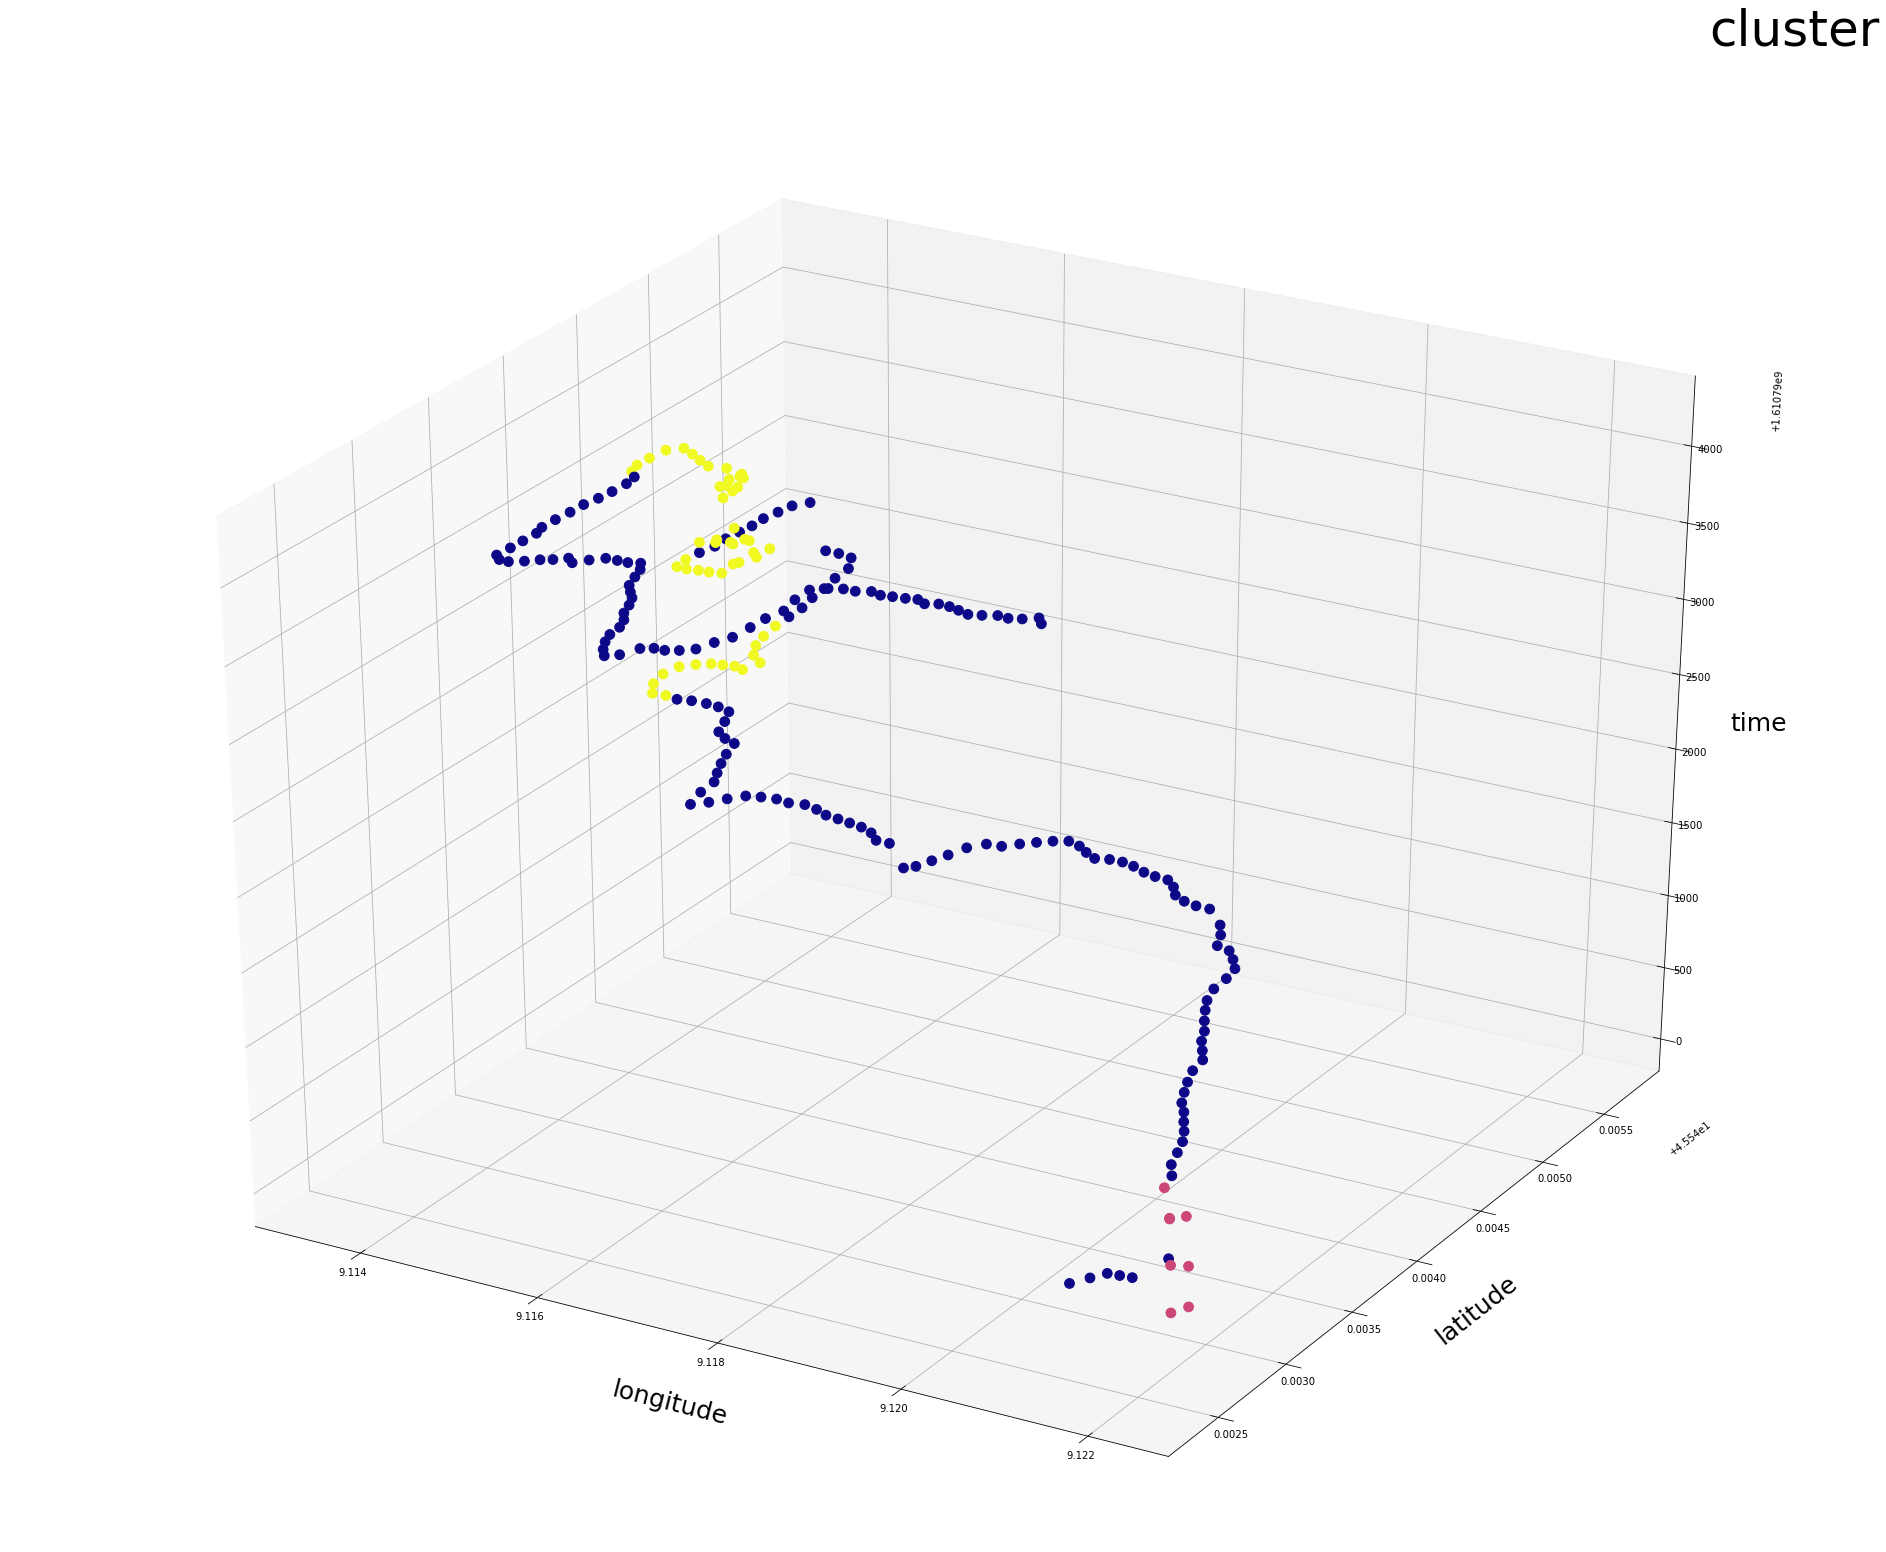

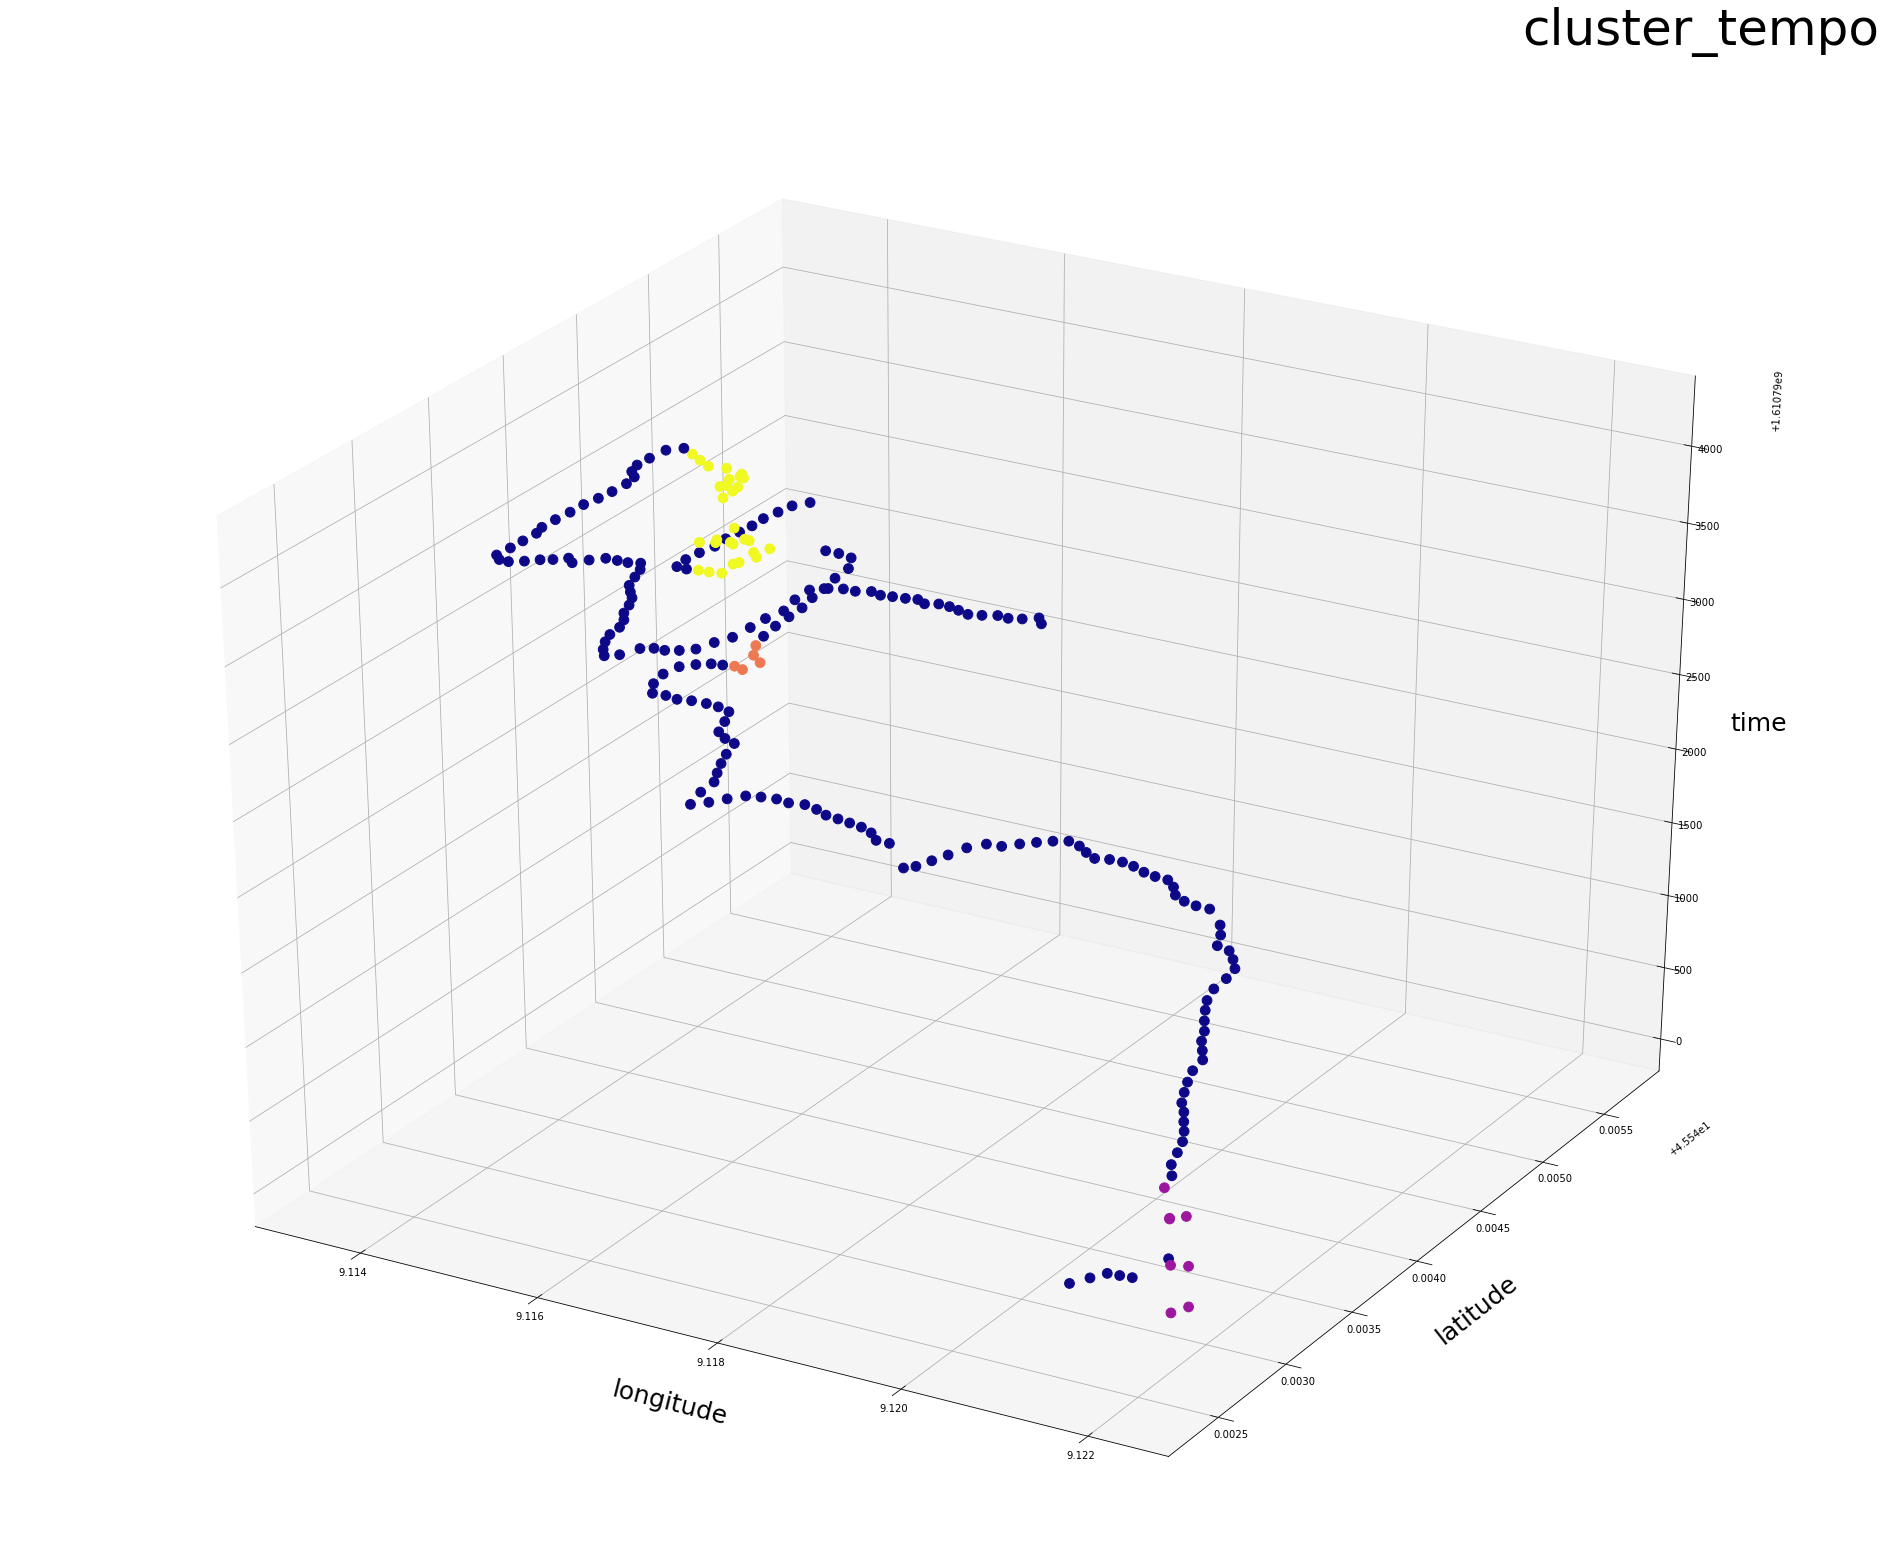

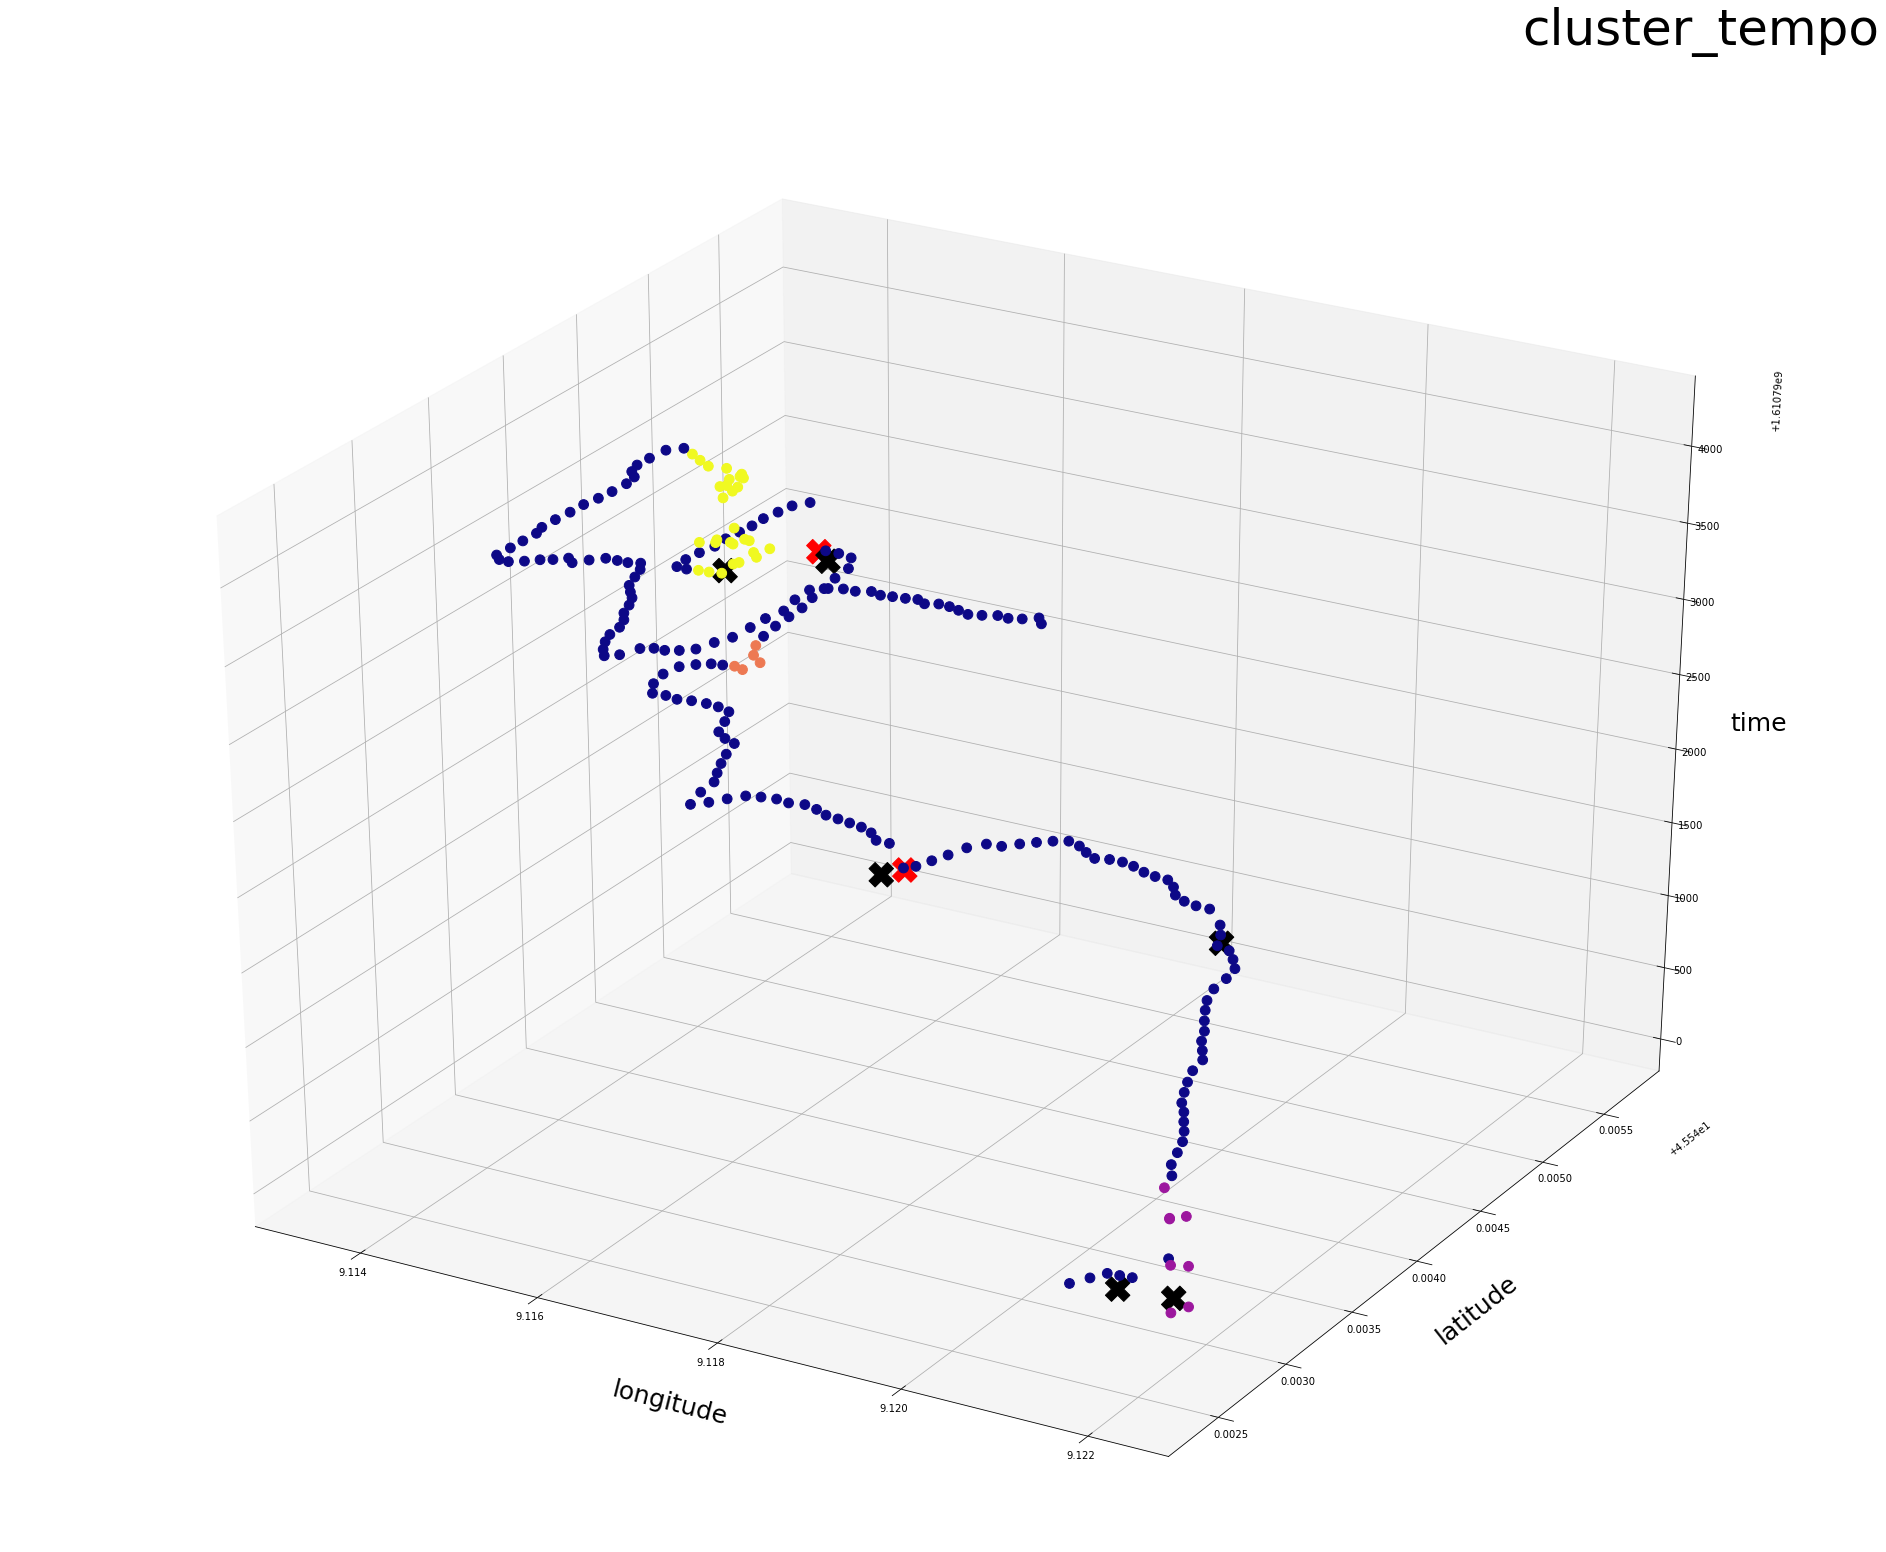

In [24]:
plot3D(tempo = False)
plot3D(tempo = True)
plot3D(tempo = True, complete = True)

### ISTOGRAMMA DELLE DISTANZE

-------------------------------------------------------------------

METODO DI ALE PER LEGGERE MAPPA DELLE STRADE DA FILE CSV

In [27]:
# query = """ drop table if exists stradevicine;
#             create table stradevicine (
#             id numeric, 
#             geom GEOMETRY(Linestring, 4326),
#             nome varchar(100));"""
# cursor.execute(query)
# connection.commit()

# with open('strademilanobollate.csv') as csv_file:
#     csv_reader = csv.reader(csv_file)
#     line_count = 0
#     for row in csv_reader: 
#         if line_count == 0: 
#             print("columns: " + row[0], row[1], row[2])
#             line_count += 1
#         else:
#             if "'" in row[2]:
#                 query = """INSERT INTO stradevicine(id,geom,nome) 
#                     VALUES({},'{}', NULL)
#                 """.format(row[0], row[1])
#             else: 
#                 query = """INSERT INTO stradevicine(id,geom,nome) 
#                     VALUES({},'{}', '{}')
#                 """.format(row[0], row[1], row[2])
#             line_count  += 1
#             cursor.execute(query)
#             connection.commit()